Here we want to explore the 10X data to see if we can 'find the ambient barcodes'

In [1]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import glob
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools
from datetime import datetime
%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
bam_infile = "../run/raw/hgmm_100_possorted_genome_bam.bam"


In [3]:
fastq_infiles = glob.glob("../run/raw/10X_fastqs/*R1*.fastq.gz")
fastq_infiles2 = glob.glob("../run/raw/10X_fastqs/*R2*.fastq.gz")


In [4]:
# extract UMI, cell and sequence qualities and derive cell and umi counts from fastqs
def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

cell_umi_counts = collections.defaultdict(set)
cell_counts = collections.Counter()

qualities = collections.defaultdict(
    lambda: collections.defaultdict(collections.Counter))

ReadExtractor = umi_methods.ExtractFilterAndUpdate(
    method="string", pattern="CCCCCCCCCCCCCCCCNNNNNNNNNN", extract_cell=True)

for fastq_infile, fastq_infile2 in zip(fastq_infiles, fastq_infiles2):
    read1s = umi_methods.fastqIterate(U.openFile(fastq_infile))
    read2s = umi_methods.fastqIterate(U.openFile(fastq_infile2))

    n = 0
    for read1 in read1s:
        read2 = next(read2s)
        n += 1
        cell, umi, umi_quals, new_seq, new_quals, new_seq2, new_quals2 = ReadExtractor.getBarcodes(read1, None)

        cell_umi_counts[cell].add(umi)
        cell_counts[cell] += 1

        cell_quals = read1.quals[:16] # extractor doesn't extract the cell quals. grrrr...
        qualities[cell]['read'].update(phredToInt(read2.quals))
        qualities[cell]['cell'].update(phredToInt(cell_quals))
        qualities[cell]['umi'].update(phredToInt(umi_quals))

        if n % 1000000 == 0:
            print("processed %iM reads" % (float(n)/1000000))

        if n == 50000000:
            break

    print("processed %i reads" % n)

processed 912145 reads
processed 911789 reads
processed 888390 reads
processed 889842 reads
processed 881438 reads
processed 908173 reads
processed 894137 reads
processed 911748 reads


In [5]:
def getCounterMean(counter):
    sum_of_numbers = sum([number*count for number, count in counter.most_common()])
    count = sum(count for n, count in counter.most_common())
    mean = sum_of_numbers / count
    return mean 

final_qualities = collections.defaultdict(lambda: collections.defaultdict(float))

for cell in qualities:
    try:
        final_qualities[cell]['read'] = getCounterMean(qualities[cell]['read'])
        final_qualities[cell]['cell'] = getCounterMean(qualities[cell]['cell'])
        final_qualities[cell]['umi'] = getCounterMean(qualities[cell]['umi'])
    except:
        print(cell)
        print(qualities['cell'])

In [9]:
rows = []
n = 0
for cell in cell_umi_counts:
    
    row = (cell, cell_counts[cell], len(cell_umi_counts[cell]),
           1-(len(cell_umi_counts[cell])/cell_counts[cell]))
    
    rows.append(row)

#print(cell_umi_counts)

In [10]:
duplication_df = pd.DataFrame.from_records(
    rows, columns=["cell", "count", "unique_umi_count", "dup._rate"])
print(duplication_df.head())
print(duplication_df.shape)
duplication_df = duplication_df[duplication_df['count']>10]
print(duplication_df.shape)

               cell  count  unique_umi_count  dup._rate
0  TACCTTATCCTAGTGA      6                 4   0.333333
1  TCTGGAAGTTGATTCG     15                 8   0.466667
2  TACGGTATCTTGCATT      6                 5   0.166667
3  TATCAGGGTTACCTGC      2                 1   0.500000
4  TGGGAAGTCGCTTAGA      6                 5   0.166667
(194304, 4)
(23965, 4)


In [11]:
duplication_df['read_qual'] = [final_qualities[cell]['read'] for cell in duplication_df['cell']]
duplication_df['umi_qual'] = [final_qualities[cell]['umi'] for cell in duplication_df['cell']]
duplication_df['cell_qual'] = [final_qualities[cell]['cell'] for cell in duplication_df['cell']]

In [12]:
%%R -i duplication_df

library(ggplot2)
library(Hmisc)

print(head(duplication_df))


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Formula

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘Hmisc’


  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-li

               cell count unique_umi_count dup._rate read_qual umi_qual
1  TCTGGAAGTTGATTCG    15                8 0.4666667  36.02653 40.81333
15 GATGCTACATCGTCGG    17               13 0.2352941  35.24010 39.18235
25 AGGGATGTCCCAGGTG    50               31 0.3800000  34.32490 40.28400
33 CGTCCATTCTGGAGCC    13                6 0.5384615  35.19623 40.83846
37 GCAGCCAAGCCCAGCT    18               11 0.3888889  32.93651 39.61667
68 CTCAGAATCTGCAGTA    11                7 0.3636364  35.14471 39.90909
   cell_qual
1   38.26250
15  37.89338
25  38.54500
33  38.97596
37  38.06944
68  38.29545


In [13]:
%%R
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)


[1] 4.276485


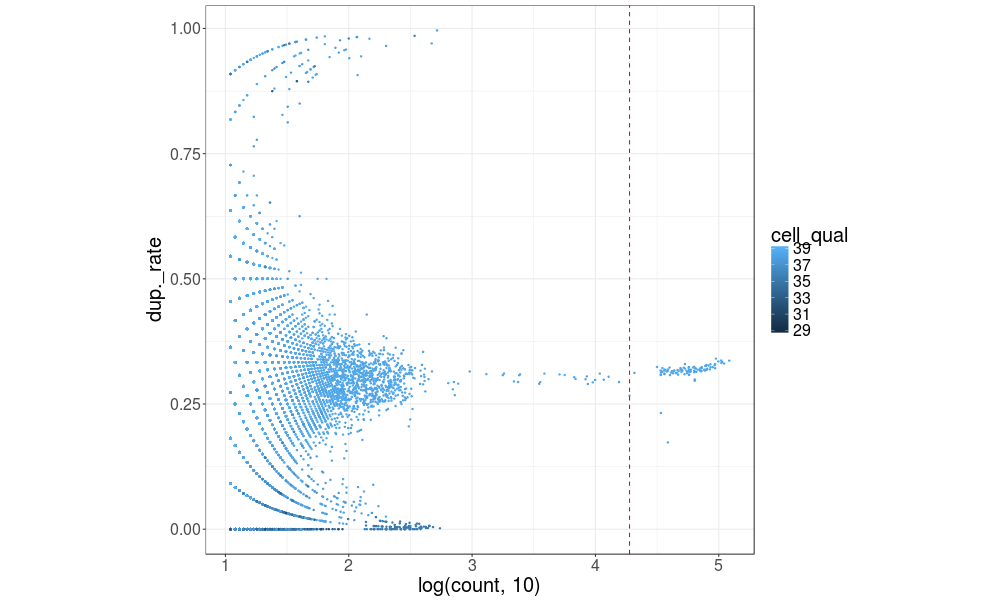

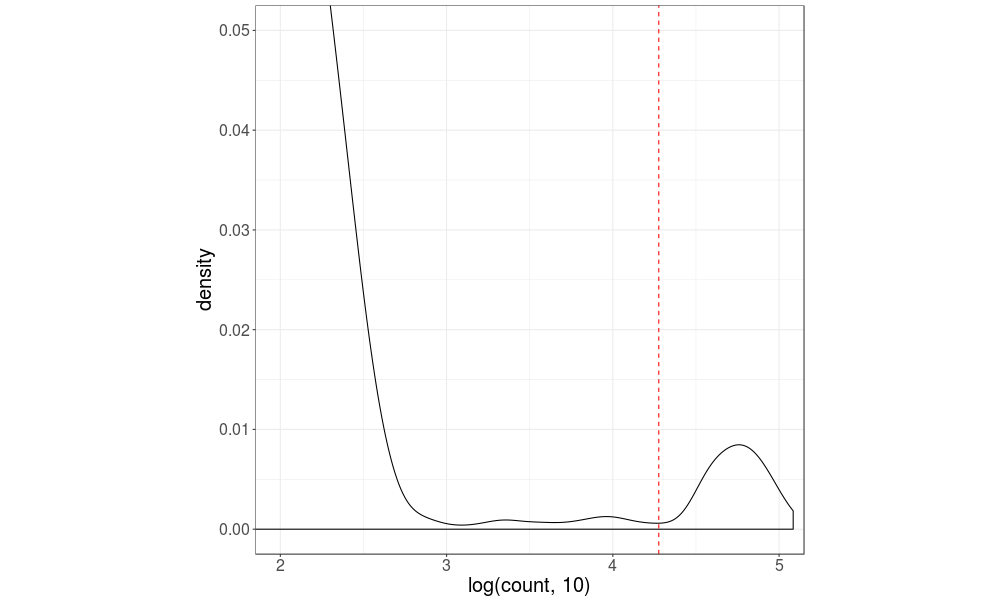

In [14]:
%%R -w 1000 -h 600
threshold = duplication_df[order(-duplication_df$count), "count"][100]
threshold_umi = duplication_df[order(-duplication_df$unique_umi_count), "unique_umi_count"][100]
print(log(threshold, 10))

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=cell_qual)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2)

print(p) 

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density(adjust = 5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(2,5), ylim=c(0,0.05))

print(p) 



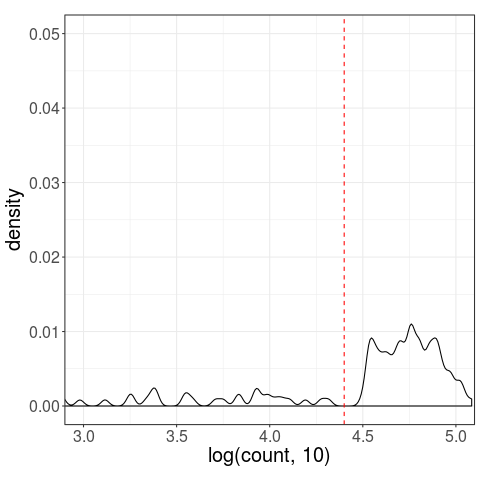

In [15]:
%%R
manual_threshold = 10^4.4
duplication_df$knee <- duplication_df$count > manual_threshold

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density() + my_theme  +
geom_vline(xintercept=log(manual_threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(3,5), ylim=c(0,0.05))

print(p) 


                   cell  count unique_umi_count dup._rate read_qual umi_qual
187447 GACTGCGAGGGCATGT 121577            80663 0.3365275  35.09538 40.17446
130038 GGTGCGTAGGCTACGA 110467            73916 0.3308771  35.20064 40.14299
127866 ATGAGGGAGTAGTGCG 106446            70898 0.3339534  35.10912 40.17046
183001 ACTGTCCTCATGCTCC 104794            70004 0.3319847  35.28750 40.24489
109018 CGAACATTCTGATACG 104616            69370 0.3369083  35.60455 40.19834
103856 ACTGTCCCATATGGTC  99208            65968 0.3350536  35.48802 40.24045
       cell_qual knee x    cum
187447  38.32145 TRUE 1 121577
130038  38.29235 TRUE 2 232044
127866  38.18460 TRUE 3 338490
183001  38.36507 TRUE 4 443284
109018  38.59106 TRUE 5 547900
103856  38.43324 TRUE 6 647108
                   cell count unique_umi_count dup._rate read_qual umi_qual
194269 TGTTCCGGTTACAGAA    11                6 0.4545455  37.22542 40.70909
       cell_qual  knee     x     cum
194269  38.89773 FALSE 23965 6679636
[1] 5924307


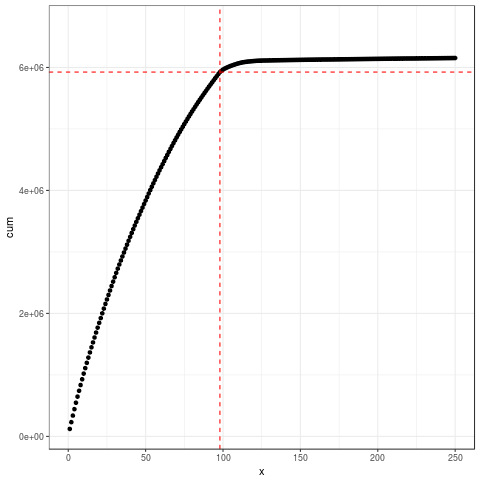

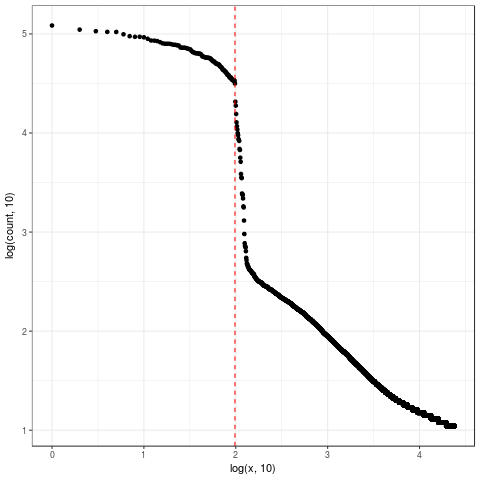

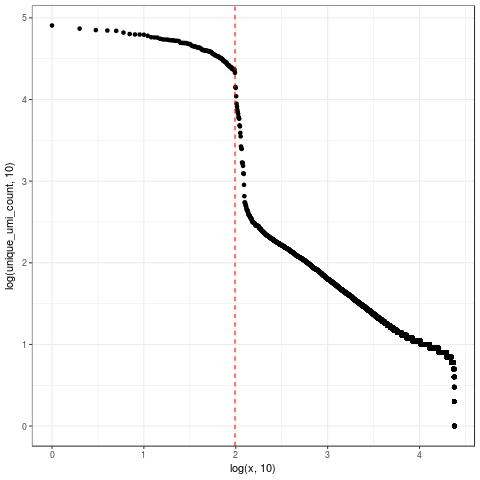

In [16]:
%%R
tmp_df <- duplication_df[order(-duplication_df$count),]
tmp_df$x <- seq(1, length(tmp_df[,1]))
tmp_df$cum <- cumsum(tmp_df$count)

tmp_df2 <- duplication_df[order(-duplication_df$unique_umi_count),]
tmp_df2$x <- seq(1, length(tmp_df2[,1]))
tmp_df2$cum <- cumsum(tmp_df2$unique_umi_count)

print(head(tmp_df))

print(tmp_df[tmp_df$x==length(tmp_df$count>manual_threshold),])

threshold_y_cum = sum(tmp_df[tmp_df$knee==TRUE, "count"])
print(threshold_y_cum)
threshold_x_cum = sum(tmp_df$knee==TRUE)

p <- ggplot(tmp_df, aes(x, cum)) + geom_point() + theme_bw() + xlim(0, 250) +
geom_hline(yintercept=threshold_y_cum, linetype=2, colour="red") +
geom_vline(xintercept=threshold_x_cum, linetype=2, colour="red")
print(p)


p <- ggplot(tmp_df, aes(log(x,10), log(count,10))) + geom_point() + theme_bw() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)

p <- ggplot(tmp_df2, aes(log(x,10), log(unique_umi_count,10))) + geom_point() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)
